In [2]:
## Import Dependencies

# General-purpose libraries
import os
import numpy as np
import pandas as pd
import warnings

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# TensorFlow and Keras for deep learning
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Dropout, BatchNormalization, 
    Activation, Embedding, Dot, Flatten
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    EarlyStopping, ModelCheckpoint, 
    LearningRateScheduler, TensorBoard
)

# Configure Jupyter Notebook to display plots inline
%matplotlib inline  

# Suppress warnings
warnings.filterwarnings("ignore")


# WORKING WITH : AINMELIST.CSV

## LOAD DATA

In [3]:
## ........Reading Data........##
INPUT_DIR  = os.path.join("..","artifacts","raw")

# Load the dataset
use_cols = ['user_id', 'anime_id', 'rating']
ratings_df = pd.read_csv(os.path.join(INPUT_DIR, "animelist.csv"), low_memory=True, usecols=use_cols)


## Display the first few rows of the dataset
print(ratings_df.shape)
ratings_df.head()

(500000, 3)


,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10


## DATA PROCESSING

In [4]:
## Filtering users with at least 400 ratings

n_ratings = ratings_df['user_id'].value_counts() # Count the number of ratings per user
ratings_df = ratings_df[ratings_df['user_id'].isin(n_ratings[n_ratings >= 400].index)]  # Filter users with at least 400 ratings


# Reset index after filtering
ratings_df.reset_index(drop=True, inplace=True)
print(ratings_df.shape)
# Display the first few rows of the filtered dataset
ratings_df.head()

(331476, 3)


,user_id,anime_id,rating
0,2,24833,0
1,2,235,10
2,2,36721,0
3,2,40956,0
4,2,31933,0


In [5]:
## Getting minimum, maximum and average ratings
min_rating = ratings_df['rating'].min()
max_rating = ratings_df['rating'].max()
avg_rating = ratings_df['rating'].mean()

print(f"Minimum Rating: {min_rating}")
print(f"Maximum Rating: {max_rating}")
print(f"Average Rating: {avg_rating:.2f}")


Minimum Rating: 0
Maximum Rating: 10
Average Rating: 4.03


In [6]:
## Scaling ratings to a 0-1 range
scaled_values = ratings_df['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values.astype(np.float64)

# Replace the scaled ratings to the DataFrame
ratings_df['rating'] = scaled_values

## Display the first few rows of the scaled dataset
ratings_df.head()


,user_id,anime_id,rating
0,2,24833,0.0
1,2,235,1.0
2,2,36721,0.0
3,2,40956,0.0
4,2,31933,0.0


In [7]:
## Getting minimum, maximum and average ratings
min_rating = ratings_df['rating'].min()
max_rating = ratings_df['rating'].max()
avg_rating = ratings_df['rating'].mean()

print(f"Minimum Rating: {min_rating}")
print(f"Maximum Rating: {max_rating}")
print(f"Average Rating: {avg_rating:.2f}")

Minimum Rating: 0.0
Maximum Rating: 1.0
Average Rating: 0.40


In [8]:
## Check for duplicates 

ratings_df.duplicated().sum()  # Check for duplicate rows -> No duplicates found

## Check for missing values
ratings_df.isnull().sum()  # Check for missing values -> No missing values found


user_id     0
anime_id    0
rating      0
dtype: int64

In [9]:
## ............. Encoding / Decoding User IDs ............. ##

## Extracting all unique userids
unique_user_ids = ratings_df['user_id'].unique().tolist()

## Encoding user IDs
user2user_encoded = {x: i for i, x in enumerate(unique_user_ids)}

## reverse mapping for user IDs
user2user_decoded = {i: x for i, x in enumerate(unique_user_ids)}

## updating the rating DataFrame with encoded user IDs
ratings_df['user'] = ratings_df['user_id'].map(user2user_encoded)
ratings_df.reset_index(drop=True, inplace=True)


In [10]:
## ............. Encoding / Decoding Anime IDs ............. ##

## Extracting all unique anime IDs
unique_anime_ids = ratings_df['anime_id'].unique().tolist()

## Encoding anime IDs
anime2anime_encoded = {x: i for i, x in enumerate(unique_anime_ids)}

## Reverse mapping for anime IDs
anime2anime_decoded = {i: x for i, x in enumerate(unique_anime_ids)}

## Updating the ratings DataFrame with encoded anime IDs
ratings_df['anime'] = ratings_df['anime_id'].map(anime2anime_encoded)
ratings_df.reset_index(drop=True, inplace=True)



In [11]:
## Shuffling the dataframe to ensure randomness
ratings_df = ratings_df.sample(frac=1, random_state=42).reset_index(drop=True)
## Display the first few rows of the updated dataset
ratings_df.head()

,user_id,anime_id,rating,user,anime
0,944,4535,0.9,260,1735
1,1470,1535,1.0,391,26
2,1567,12115,0.0,409,1023
3,681,36474,0.7,177,2052
4,386,1454,0.7,98,2304


## TRAINING DATA

In [12]:
## ............. Splitting the dataset into training and testing sets ............. ##

# defining features and target variable
features = ['user', 'anime']
target = 'rating'

# Splitting the dataset into features and target sets
X = ratings_df[features].values
y = ratings_df[target].values

# Splitting the dataset into training and testing sets
test_size = 2000 # Number of samples for the test set
train_indices = np.arange(len(X) - test_size)
test_indices = np.arange(len(X) - test_size, len(X))

# Creating training and testing sets
X_train, X_test = X[train_indices], X[test_indices]
y_train, y_test = y[train_indices], y[test_indices]


# Display the shapes of the training and testing sets
print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Testing set shape: {X_test.shape}, {y_test.shape}")

## Check the format of the training and testing sets
print(f"Training set format: {type(X_train)}")
print(f"Training set format: {type(y_train)}")


## Create seperate list to hold user and anime IDs for training and testing sets
X_train_list = [X_train[:, 0], X_train[:, 1]]
X_test_list = [X_test[:, 0], X_test[:, 1]]


## Check the format of the training and testing sets
print(f"X_train_list format: {type(X_train_list)}")
print(f"X_test_list format: {type(X_test_list)}")

Training set shape: (329476, 2), (329476,)
Testing set shape: (2000, 2), (2000,)
Training set format: <class 'numpy.ndarray'>
Training set format: <class 'numpy.ndarray'>
X_train_list format: <class 'list'>
X_test_list format: <class 'list'>


## MODEL ARCHITECTURE

In [13]:
## Defining the structure of MODEL 

def RecommenderNet():
    # embedding dimensions
    embedding_dim = 128

    ## defining the input for users and anime
    user = Input(shape=(1,), name='user')
    anime = Input(shape=(1,), name='anime')

    ## defining the embedding layers for users and anime
    user_embedding = Embedding(name = 'user_embedding', input_dim=len(unique_user_ids), output_dim=embedding_dim)(user)
    anime_embedding = Embedding(name = 'anime_embedding', input_dim=len(unique_anime_ids), output_dim=embedding_dim)(anime)

    ## Making the DOT layer to calculate the dot product of user and anime embeddings (signifies similarity between user and anime)
    dot_product = Dot(name = 'dot_product', normalize= True ,axes=2)([user_embedding, anime_embedding])

    ## Flattening the dot product output
    flatten = Flatten(name='flatten')(dot_product)

    ## Adding a dense layer with ReLU activation
    dense = Dense(1, kernel_initializer= 'he_normal')(flatten)
    dense = BatchNormalization(name='batch_norm')(dense)
    dense = Activation('sigmoid')(dense)

    ## Creating the model
    model = Model(inputs=[user, anime], outputs=dense)
    model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['mae', 'mse'])

    return model


# initializing the model
model = RecommenderNet()
# Display the model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 128)    │     54,528 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 128)    │  1,624,192 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product (Dot)   │ (None, 1, 1)      │          0 │ user_embedding[0… │
│                     │                   │            │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1)         │          0 │ dot_product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │          2 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_norm          │ (None, 1)         │          4 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1)         │          0 │ batch_norm[0][0]  │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,678,726 (6.40 MB)

 Trainable params: 1,678,724 (6.40 MB)

 Non-trainable params: 2 (8.00 B)

In [14]:
## Preparing the callbacks for training
start_lr = 0.005        # Initial learning rate
min_lr = 0.0001         # Minimum learning rate
max_lr = 0.001          # Maximum learning rate
batch_size = 1000      # Batch size for training
rampup_epochs = 5       # Number of epochs to gradually increase the learning rate
sustain_epochs = 10     # Number of epochs to sustain the maximum learning rate
exp_decay = 0.8         # Exponential decay factor for learning rate


## Learning Rate Scheduler Function
def lrfn(epoch):
    if epoch < rampup_epochs:
        lr = (max_lr - start_lr) / rampup_epochs * epoch + start_lr

    elif epoch < rampup_epochs + sustain_epochs:
        lr = max_lr

    else:
        lr = (max_lr - min_lr)*exp_decay**(epoch - rampup_epochs - sustain_epochs) + min_lr
        
    return lr



# Early stopping callback to stop training if validation loss does not improve
lr_callback = LearningRateScheduler(lrfn)  # Learning rate scheduler callback
checkpoint_filepath = "./weights.weights.h5"                           # File path to save the model weights

model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath, 
    save_weights_only=True,
    monitor='val_loss', 
    save_best_only=True, 
    mode='min', 
    verbose=1
)  # Model checkpoint callback to save the best model weights

# Early stopping callback to stop training if validation loss does not improve
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=3, 
    verbose=1, 
    mode='min', 
    restore_best_weights=True
)  # Early stopping callback to stop training if validation loss does not improve

In [15]:
# List of callbacks to be used during training
my_callbacks = [ model_checkpoint, lr_callback, early_stopping]  

## Training the model
history = model.fit(
    x=X_train_list, 
    y=y_train, 
    batch_size=batch_size, 
    epochs=20, 
    verbose=1,
    validation_data = (X_test_list, y_test), 
    callbacks=my_callbacks
)

Epoch 1/20
330/330 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6840 - mae: 0.3365 - mse: 0.1495
Epoch 1: val_loss improved from inf to 0.54947, saving model to ./weights.weights.h5
330/330 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.6838 - mae: 0.3364 - mse: 0.1494 - val_loss: 0.5495 - val_mae: 0.2588 - val_mse: 0.0941 - learning_rate: 0.0050
Epoch 2/20
329/330 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.4668 - mae: 0.1944 - mse: 0.0584
Epoch 2: val_loss did not improve from 0.54947
330/330 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.4668 - mae: 0.1943 - mse: 0.0584 - val_loss: 0.5596 - val_mae: 0.2489 - val_mse: 0.0990 - learning_rate: 0.0042
Epoch 3/20
328/330 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.4039 - mae: 0.1386 - mse: 0.0350
Epoch 3: val_loss did not improve from 0.54947
330/330 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.4040 - mae: 0.1386 - mse: 0.0350 - val_loss: 0.5685 - val_mae: 0.2409 - val_mse: 0.1006 - learning_rate: 0.0034
Epoch 4/20
330/330 ━━━━━━━━━━━━━━━━━━━━ 

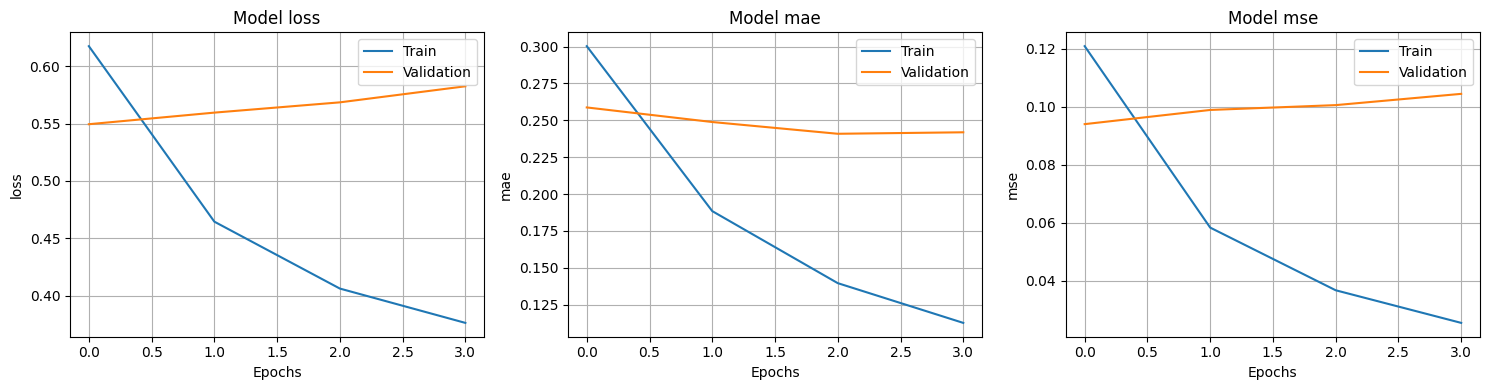

In [16]:
## Visulaizingthe training history
metrics = ['loss', 'mae', 'mse']

# Create Subplots for each metric
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

# Plot each metric
for i, metric in enumerate(metrics):
    axes[i].plot(history.history[metric], label='Train')
    axes[i].plot(history.history['val_' + metric], label='Validation')
    axes[i].set_title(f'Model {metric}')
    axes[i].set_xlabel('Epochs')
    axes[i].set_ylabel(metric)
    axes[i].legend()
    axes[i].grid(True)
# Adjust layout
plt.tight_layout()
plt.show()

In [17]:
## Extract weights for user and anime from the trained model

def extract_weights(name, model):
    """
    Extracts the weights from the trained model.
    
    """
    # Retrieve the specified layer from the model
    weight_layer = model.get_layer(name)
    
    # Extract the weights of the layer
    weight = weight_layer.get_weights()[0]
    
    # Normalize the weights using L2 norm
    weight = weight / np.linalg.norm(weight, axis=1).reshape((-1, 1))

    
    return weight


## anime_weights = extract_weights('anime_embedding', model)
anime_weights = extract_weights('anime_embedding', model)

## user_weights = extract_weights('user_embedding', model)
user_weights = extract_weights('user_embedding', model)

# WORKING WITH : ANIME.CSV AND ANIME_WITH_SYNOPSIS.CSV

In [18]:
## ........Reading Data........##
INPUT_DIR = os.path.join("..","artifacts","raw")

### Load the dataset anime.csv
anime_df = pd.read_csv(os.path.join(INPUT_DIR, "anime.csv"), low_memory=True)
# Change column name of MAL_ID to anime_id
anime_df.rename(columns={'MAL_ID': 'anime_id'}, inplace=True)


anime_synopsis_df = pd.read_csv(os.path.join(INPUT_DIR, "anime_with_synopsis.csv"), low_memory=True)
# Change column name of MAL_ID to anime_id
anime_synopsis_df.rename(columns={'MAL_ID': 'anime_id'}, inplace=True)


## Display the first few rows of the dataset
print(anime_df.shape)
display(anime_df.head(2))

print(anime_synopsis_df.shape)
display(anime_synopsis_df.head())

(17562, 35)


,anime_id,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0


(16214, 5)


,anime_id,Name,Score,Genres,sypnopsis
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever..."
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of ..."
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen","Vash the Stampede is the man with a $$60,000,0..."
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",ches are individuals with special powers like ...
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",It is the dark century and the people are suff...


## Preproccing : ANIME.CSV

In [19]:
display(anime_df.head(2))

,anime_id,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0


In [20]:
## Replace 'Unknown' with NaN in the dataframe:
anime_df.replace('Unknown', None, inplace=True)

## Function to extract anime name based on the anime ID:

def get_anime_name(anime_id):
    """
    Returns the anime name based on the anime ID.

    First try to extract the English name and if not available then try to extract the Japanese name.
    """
    if anime_id in anime_df['anime_id'].values:
        # Filter the row corresponding to the anime_id
        anime_row = anime_df.loc[anime_df['anime_id'] == anime_id]

        # Try to get the English name first
        name = anime_row['English name'].values[0]
        if not name:  # If English name is None or empty
            name = anime_row['Name'].values[0]  # Fallback to Japanese name

        return name

    # If the anime_id is not found in the anime DataFrame, return NaN
    return np.nan
    
    
## Making a new column in the dataframe to store the anime names (priority to English name, if not available then Japanese name)
anime_df['eng_version'] = anime_df['anime_id'].apply(get_anime_name)
## Display the first few rows of the updated anime DataFrame
display(anime_df.head(2))


,anime_id,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,eng_version
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0,Cowboy Bebop
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",None,...,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0,Cowboy Bebop:The Movie


In [21]:
## Sorting the dataframe based on the 'Score' column in descending order
anime_df.sort_values(by  = 'Score', ascending=False, inplace=True)

## Filtering fewer columns only:
cols = ['anime_id','eng_version','Score','Genres','Episodes','Type', 'Premiered','Members' ]
anime_df = anime_df[cols]
## Resetting the index of the dataframe
anime_df.reset_index(drop=True, inplace=True)

## Display the first few rows of the final anime DataFrame
display(anime_df.head(5))


,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
0,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",64,TV,Spring 2009,2248456
1,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,733260
2,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162
3,38524,Attack on Titan Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Sho...",10,TV,Spring 2019,1073626
4,28977,Gintama Season 4,9.1,"Action, Comedy, Historical, Parody, Samurai, S...",51,TV,Spring 2015,404121


In [22]:
## Function to extract anime data based on id or the name: 

def get_anime_frame(anime, df):
    # if the instance is integer:
    if isinstance(anime, int):
        # Check if the anime_id exists in the DataFrame
        if anime in df['anime_id'].values:
            # Return the row corresponding to the anime_id
            return df[df['anime_id'] == anime]
        else:
            return None
        
    # if the instance is string:
    elif isinstance(anime, str):
        # Check if the anime name exists in the DataFrame
        if anime in df['eng_version'].values:
            # Return the row corresponding to the anime name
            return df[df['eng_version'] == anime]
        else:
            return None
    else:
        return None
    
## Function to get the anime details based on the anime ID or name
display(get_anime_frame(1, anime_df))
display(get_anime_frame('Naruto', anime_df))

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
28,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",26,TV,Spring 1998,1251960


,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
664,20,Naruto,7.91,"Action, Adventure, Comedy, Super Power, Martia...",220,TV,Fall 2002,1830540


## Preproccing : ANIME_WITH_SYNOPSYS.CSV

In [23]:
# Select relevant columns from the anime_with_synopsis dataset
cols = ['anime_id', 'Name', 'Genres', 'sypnopsis']

# Filter the anime_synopsis_df to retain only the selected columns
anime_synopsis_df = anime_synopsis_df[cols]

# Display the first few rows of the filtered dataset
anime_synopsis_df.head()

,anime_id,Name,Genres,sypnopsis
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever..."
1,5,Cowboy Bebop: Tengoku no Tobira,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of ..."
2,6,Trigun,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen","Vash the Stampede is the man with a $$60,000,0..."
3,7,Witch Hunter Robin,"Action, Mystery, Police, Supernatural, Drama, ...",ches are individuals with special powers like ...
4,8,Bouken Ou Beet,"Adventure, Fantasy, Shounen, Supernatural",It is the dark century and the people are suff...


In [24]:
## Function to extract Synopsis data based on id or the name: 

def get_synopsys(anime, df):
    # if the instance is integer:
    if isinstance(anime, int):
        # Check if the anime_id exists in the DataFrame
        if anime in df['anime_id'].values:
            # Return the row corresponding to the anime_id
            return df[df['anime_id'] == anime]['sypnopsis'].values[0]
        else:
            return None
        
    # if the instance is string:
    elif isinstance(anime, str):
        # Check if the anime name exists in the DataFrame
        if anime in df['Name'].values:
            # Return the row corresponding to the anime name
            return df[df['Name'] == anime]['sypnopsis'].values[0]
        else:
            return None
    else:
        return None
    
## Function to get the anime details based on the anime ID or name
display(get_synopsys(1, anime_synopsis_df))
display(get_synopsys('Naruto', anime_synopsis_df))

'In the year 2071, humanity has colonized several of the planets and moons of the solar system leaving the now uninhabitable surface of planet Earth behind. The Inter Solar System Police attempts to keep peace in the galaxy, aided in part by outlaw bounty hunters, referred to as "Cowboys." The ragtag team aboard the spaceship Bebop are two such individuals. Mellow and carefree Spike Spiegel is balanced by his boisterous, pragmatic partner Jet Black as the pair makes a living chasing bounties and collecting rewards. Thrown off course by the addition of new members that they meet in their travels—Ein, a genetically engineered, highly intelligent Welsh Corgi; femme fatale Faye Valentine, an enigmatic trickster with memory loss; and the strange computer whiz kid Edward Wong—the crew embarks on thrilling adventures that unravel each member\'s dark and mysterious past little by little. Well-balanced with high density action and light-hearted comedy, Cowboy Bebop is a space Western classic an

"moments prior to Naruto Uzumaki's birth, a huge demon known as the Kyuubi, the Nine-Tailed Fox, attacked Konohagakure, the Hidden Leaf Village, and wreaked havoc. In order to put an end to the Kyuubi's rampage, the leader of the village, the Fourth Hokage, sacrificed his life and sealed the monstrous beast inside the newborn Naruto. Now, Naruto is a hyperactive and knuckle-headed ninja still living in Konohagakure. Shunned because of the Kyuubi inside him, Naruto struggles to find his place in the village, while his burning desire to become the Hokage of Konohagakure leads him not only to some great new friends, but also some deadly foes."

# CONTENT BASED RECOMMENDATION SYSTEM

In [25]:
## Setting the column width to maximum
pd.set_option('display.max_colwidth', None)

In [26]:
## FUNCTION TO GET CONNENT BASED RECOMMENDATIONS

def get_similar_recommendations(name, anime_weights , anime2anime_encoded , anime2anime_decoded , df , synopsys_df , n = 10,  return_dist = False , neg = False):
    """
    Returns the top n similar anime recommendations based on the input anime name or ID.
    
    Parameters:
    - name: str or int, the name or ID of the anime to find similar recommendations for.
    - anime_weights: np.array, the weights of the anime embeddings.
    - anime2anime_encoded: dict, mapping of anime IDs to encoded values.
    - anime2anime_decoded: dict, mapping of encoded values back to anime IDs.
    - df: pd.DataFrame, DataFrame containing anime details.
    - synopsys_df: pd.DataFrame, DataFrame containing anime synopses.
    - n: int, number of recommendations to return (default is 10).
    - return_dist: bool, whether to return distances along with recommendations (default is False).
    - neg: bool, whether to return negative recommendations (default is False).
    
    Returns:
    - A DataFrame containing the top n similar anime recommendations.
    """
    try:
        # get the index of the anime 
        index = get_anime_frame(name, df).anime_id.values[0]

        # get the encoded value of the anime
        encoded_index = anime2anime_encoded[index]

        # get the weights of the anime
        dists = np.dot( anime_weights, anime_weights[encoded_index] )

        # sorting the distances in descending order
        sorted_dists= np.argsort(dists)
        
        # While recommendation include the anime itself
        n +=1 

        # if neg is True, then we will return the negative recommendations
        if neg:
            closest  = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]

        similarity_arr= []

        for close in closest:
            # Get the anime ID from the encoded value
            anime_id = anime2anime_decoded[close]

            # Get the synopsis of the anime
            synopsis = get_synopsys(anime_id, synopsys_df)

            # Get Anime frame:
            anime_frame = get_anime_frame(anime_id, df)

            if return_dist:
                return dists , closest

            ## Extract all the relevant details from the anime frame
            anime_details = {
                'anime_id': anime_frame['anime_id'].values[0],
                'NAME': anime_frame['eng_version'].values[0],
                'Score': anime_frame['Score'].values[0],
                'Genres': anime_frame['Genres'].values[0],
                'Similarity': dists[close],
                'Episodes': anime_frame['Episodes'].values[0],
                'Type': anime_frame['Type'].values[0],
                'Premiered': anime_frame['Premiered'].values[0],
                'Members': anime_frame['Members'].values[0],
                'Synopsis': synopsis,
            }

            ## Append the anime details to the similarity array
            similarity_arr.append(anime_details)


        # Create a DataFrame from the similarity array
        recommendations_df = pd.DataFrame(similarity_arr).sort_values(by='Similarity', ascending=False)

        # display(recommendations_df)

        # return recommendations_df[recommendations_df.anime_id != index].drop(['anime_id'] , axis = 1).reset_index(drop = True)
        return recommendations_df.drop(['anime_id'], axis = 1).reset_index(drop = True)


    except:
        print ('ERROR : Anime not found in the database. Please check the anime name or ID.')
        return None


get_similar_recommendations("Steins;Gate", anime_weights, anime2anime_encoded, anime2anime_decoded, anime_df, anime_synopsis_df, n=2, return_dist = False,  neg=False)
    

,NAME,Score,Genres,Similarity,Episodes,Type,Premiered,Members,Synopsis
0,Steins;Gate,9.11,"Thriller, Sci-Fi",1.000000,24,TV,Spring 2011,1771162,"The self-proclaimed mad scientist Rintarou Okabe rents out a room in a rickety old building in Akihabara, where he indulges himself in his hobby of inventing prospective ""future gadgets"" with fellow lab members: Mayuri Shiina, his air-headed childhood friend, and Hashida Itaru, a perverted hacker nicknamed ""Daru."" The three pass the time by tinkering with their most promising contraption yet, a machine dubbed the ""Phone Microwave,"" which performs the strange function of morphing bananas into piles of green gel. Though miraculous in itself, the phenomenon doesn't provide anything concrete in Okabe's search for a scientific breakthrough; that is, until the lab members are spurred into action by a string of mysterious happenings before stumbling upon an unexpected success—the Phone Microwave can send emails to the past, altering the flow of history. Adapted from the critically acclaimed visual novel by 5pb. and Nitroplus, Steins;Gate takes Okabe through the depths of scientific theory and practicality. Forced across the diverging threads of past and present, Okabe must shoulder the burdens that come with holding the key to the realm of time."
1,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen",0.698947,64,TV,Spring 2009,2248456,"""In order for something to be obtained, something of equal value must be lost."" Alchemy is bound by this Law of Equivalent Exchange—something the young brothers Edward and Alphonse Elric only realize after attempting human transmutation: the one forbidden act of alchemy. They pay a terrible price for their transgression—Edward loses his left leg, Alphonse his physical body. It is only by the desperate sacrifice of Edward's right arm that he is able to affix Alphonse's soul to a suit of armor. Devastated and alone, it is the hope that they would both eventually return to their original bodies that gives Edward the inspiration to obtain metal limbs called ""automail"" and become a state alchemist, the Fullmetal Alchemist. Three years of searching later, the brothers seek the Philosopher's Stone, a mythical relic that allows an alchemist to overcome the Law of Equivalent Exchange. Even with military allies Colonel Roy Mustang, Lieutenant Riza Hawkeye, and Lieutenant Colonel Maes Hughes on their side, the brothers find themselves caught up in a nationwide conspiracy that leads them not only to the true nature of the elusive Philosopher's Stone, but their country's murky history as well. In between finding a serial killer and racing against time, Edward and Alphonse must ask themselves if what they are doing will make them human again... or take away their humanity."
2,One Punch Man,8.57,"Action, Sci-Fi, Comedy, Parody, Super Power, Supernatural",0.697240,12,TV,Fall 2015,2123866,"The seemingly ordinary and unimpressive Saitama has a rather unique hobby: being a hero. In order to pursue his childhood dream, he trained relentlessly for three years—and lost all of his hair in the process. Now, Saitama is incredibly powerful, so much so that no enemy is able to defeat him in battle. In fact, all it takes to defeat evildoers with just one punch has led to an unexpected problem—he is no longer able to enjoy the thrill of battling and has become quite bored. This all changes with the arrival of Genos, a 19-year-old cyborg, who wishes to be Saitama's disciple after seeing what he is capable of. Genos proposes that the two join the Hero Association in order to become certified heroes that will be recognized for their positive contributions to society, and Saitama, shocked that no one knows who he is, quickly agrees. And thus begins the story of One Punch Man , an action-comedy that follows an eccentric individual who longs to fight strong enemies that can hopefully give him the excitement he once felt and just ma

# USER BASED RECOMMENDATION SYSTEM

In [77]:
def find_similar_users(user_id, user_weights, user2user_encoded, user2user_decoded, n = 10, return_dist = False, negative = False ):
    '''
    Returns the top n similar users based on the input user ID.
    Parameters:
    - user_id: int, the ID of the user to find similar users for.
    - user_weights: np.array, the weights of the user embeddings.
    - user2user_encoded: dict, mapping of user IDs to encoded values.
    - user2user_decoded: dict, mapping of encoded values back to user IDs.
    - n: int, number of similar users to return (default is 10).
    - return_dist: bool, whether to return distances along with similar users (default is False).
    - negative: bool, whether to return negative recommendations (default is False).
    Returns:
    - A DataFrame containing the top n similar users.
    '''

    try:

        ## Check if the user_id exists in the user2user_encoded mapping 

        if user_id not in user2user_encoded:
            print(f"ERROR: User ID {user_id} not found in the database.")
            return None
        
        # Get the encoded value of the user
        encoded_user_id = user2user_encoded[user_id]

        # Calculate the distances between the user weights and the specified user
        dists = np.dot(user_weights, user_weights[encoded_user_id])

        # Sort the distances in descending order
        sorted_dists = np.argsort(dists)

        # While recommendation include the user itself
        n += 1
        # If negative is True, then we will return the negative recommendations
        if negative:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]

        
        
        similarity_arr = []

        for close in closest:
            # Get the user ID from the encoded value
            user = user2user_decoded[close]

            # Extract relevant details for the user
            user_details = {
                'similar_user_id': user,
                'Similarity': dists[close],
            }

            # Append the user details to the similarity array
            similarity_arr.append(user_details)

        # Create a DataFrame from the similarity array
        similar_users = pd.DataFrame(similarity_arr).sort_values(by='Similarity', ascending=False)

        # removing the user itself from the recommendations
        similar_users = similar_users[similar_users.similar_user_id != user_id].reset_index(drop=True)

        if return_dist:
            return similar_users, dists, closest

        return similar_users  # Return the top n similar users



    except:
        print ('ERROR : User not found in the database. Please check the user ID.')
        return None
    

find_similar_users(1420,  user_weights, user2user_encoded, user2user_decoded, n = 10, return_dist = False, negative = False )

,similar_user_id,Similarity
0,1244,0.554802
1,1407,0.479614
2,853,0.476329
3,1107,0.447306
4,1101,0.431193
5,320,0.430383
6,437,0.426808
7,1612,0.418244
8,314,0.417414
9,1483,0.411509


### VISUALIZATION

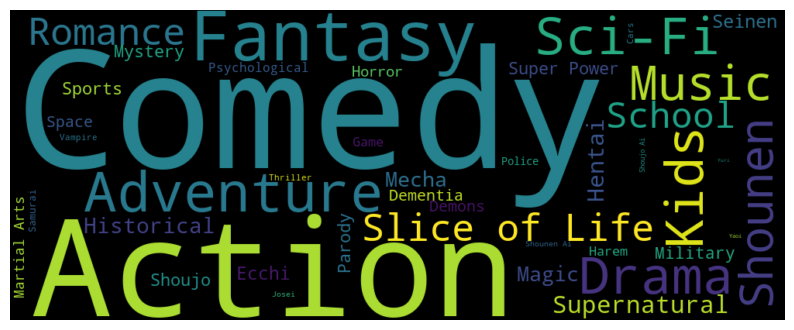

In [28]:
## Function to visualize wordcloud of genres:
from collections import Counter
def visualize_genre(genres):
    """
    Visualizes the genres of anime using a word cloud.
    
    Parameters:
    - genres: str, a string containing the genres of anime.
    
    Returns:
    - None
    
    """

    # Create a word cloud from the genres
    wordcloud = WordCloud(width=1000, height=400, background_color='black').generate_from_frequencies(genres)

    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# Concatenate all genres into a single string
genre_list = [j.lstrip() for i in anime_df['Genres'].dropna().astype(str).tolist() for j in i.split(',')]

# Count the frequency of each genre
genre_counts = Counter(genre_list)

# Visualize the genres using the word cloud
visualize_genre(genre_counts)


### USER PREFERENCES

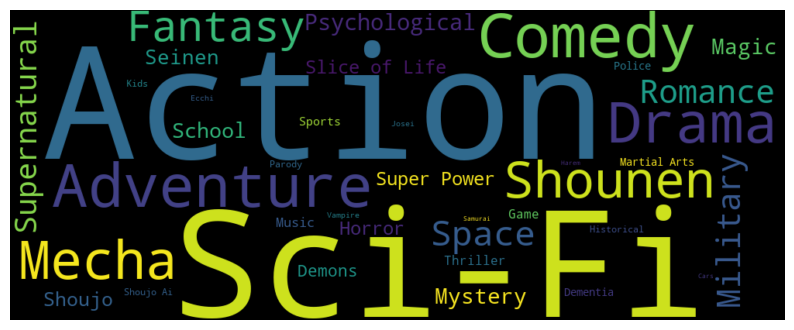

,eng_version,Genres
5,Hunter x Hunter,"Action, Adventure, Fantasy, Shounen, Super Power"
7,Legend of the Galactic Heroes,"Military, Sci-Fi, Space, Drama"
22,Spirited Away,"Adventure, Supernatural, Drama"
28,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space"
29,Monster,"Drama, Horror, Mystery, Police, Psychological, Seinen, Thriller"
...,...,...
6606,Detonator Orgun,"Action, Sci-Fi, Mecha"
7172,Casshan:Robot Hunter,"Adventure, Mecha, Sci-Fi"
7261,Yu-Gi-Oh! Zexal,"Action, Game, Fantasy, Shounen"
8425,The Ideon:A Contact,"Sci-Fi, Space, Drama, Mecha"


In [29]:
## Function to get the user preferences:

def get_user_preferences(user_id, ratings_df,anime_df, plot = False):

    ## Get all the ratings given by the user for animes
    anime_watched_user = ratings_df[ratings_df['user_id'] == user_id]

    ## If the user has not watched any anime, return None
    if anime_watched_user.empty:
        print(f"User ID {user_id} has not watched any anime.")
        return None
    
    ## Get top 10% animes rated by the user:
    n = 10
    percentile_ = np.percentile(anime_watched_user['rating'], 100 - n)
    anime_watched_user = anime_watched_user[anime_watched_user['rating'] >= percentile_].sort_values(by = 'rating', ascending = False) ## Filtering high rated anime

    ## Getting anime ids from the sorted dataframe
    top_anime_user = anime_watched_user['anime_id'].tolist()

    ## Getting anime rows from top animes
    top_anime_user = anime_df[anime_df['anime_id'].isin(top_anime_user)][['eng_version' , 'Genres']]

    if plot == True:
        ## Visualizing the genres of the top animes watched by the user
        genre_list = [j.lstrip() for i in top_anime_user['Genres'].dropna().astype(str).tolist() for j in i.split(',')]
        genre_counts = Counter(genre_list)
        visualize_genre(genre_counts)



    return top_anime_user


#  Getting Preferences:
get_user_preferences(1420, ratings_df,anime_df, plot = True)

### User Based Recommendations


In [133]:
def get_user_recomendations(user_id,user_weights,user2user_encoded,user2user_decoded, anime_df, ratings_df,synopsis_df,n=5):
    try:
        ## Get similar users:
        similar_users = find_similar_users(user_id, user_weights, user2user_encoded, user2user_decoded, n=n, return_dist=False, negative=False)

        ## Get user preferences:
        user_preferences = get_user_preferences(user_id, ratings_df,anime_df, plot = False)

        ## Empty list to hold recommendations
        recommendation_animes = []
        anime_list = []

        ## Loop through each similar user
        for user_id in similar_users.similar_user_id.values:
            ## Extracting preferences of all the users 
            pref_list = get_user_preferences(int(user_id), ratings_df,anime_df)

            ## Filter all animes which are already rated by current user
            pref_list = pref_list[~pref_list.eng_version.isin(user_preferences.eng_version.values)]

            ## if the pref list is not empty then append the list to anime_list
            if not pref_list.empty:
                anime_list.append(pref_list)


        ## Concatinate all the animes together:
        if not isinstance(anime_list, list) or not all(isinstance(df, pd.DataFrame) for df in anime_list):
            raise ValueError("Input must be a list of pandas DataFrames.")
    
        anime_user_df =  pd.concat(anime_list, ignore_index=False)

        # get top n anime recommendation: 
        for (anime_id, n_liked) in anime_user_df.eng_version.value_counts()[:n].items():
                # Get anime frame:
                anime_frame = get_anime_frame(anime_id, anime_df)
            
                anime_details = {
                'anime_id': anime_frame['anime_id'].values[0],
                'NAME': anime_frame['eng_version'].values[0],
                'Score': anime_frame['Score'].values[0],
                'Users liked' : n_liked,
                'Genres': anime_frame['Genres'].values[0],
                'Episodes': anime_frame['Episodes'].values[0],
                'Type': anime_frame['Type'].values[0],
                'Premiered': anime_frame['Premiered'].values[0],
                'Members': anime_frame['Members'].values[0],
                'Synopsis': get_synopsys(int(anime_frame['anime_id'].values[0]), synopsis_df)
                }

                ## Appending this data to recommendation_animes
                recommendation_animes.append(anime_details)
        


        return pd.DataFrame(recommendation_animes)


    except Exception as e:
        print('ERROR: User-based recommendations not implemented yet.', e)
        return None
    

## get recommendations:
data=  get_user_recomendations(1627,user_weights,user2user_encoded,user2user_decoded, anime_df, ratings_df,anime_synopsis_df,n=5)
data

,anime_id,NAME,Score,Users liked,Genres,Episodes,Type,Premiered,Members,Synopsis
0,12365,Bakuman.,8.58,5,"Comedy, Drama, Romance, Shounen",25,TV,Fall 2012,268794,"Onto their third serialization, manga duo Moritaka Mashiro and Akito Takagi—also known by their pen name, Muto Ashirogi—are ever closer to their dream of an anime adaption. However, the real challenge is only just beginning: if they are unable to compete with the artist Eiji Niizuma in the rankings within the span of six months, they will be canceled. To top it off, numerous rivals are close behind and declaring war. They don't even have enough time to spare thinking about an anime! In Bakuman. 3rd Season , Muto Ashirogi must find a way to stay atop the colossal mountain known as the Shounen Jack rankings. With new problems and new assistants, the pair continue to strive for their dream."
1,31637,GATE,7.77,4,"Action, Military, Adventure, Fantasy",12,TV,Winter 2016,413838,"Several months have passed since the infamous Ginza Incident, with tensions between the Empire and JSDF escalating in the vast and mysterious ""Special Region"" over peace negotiations. The greed and curiosity of the global powers have also begun to grow, as reports about the technological limitations of the magical realm's archaic civilizations come to light. Meanwhile, Lieutenant Youji Itami and his merry band of female admirers struggle to navigate the complex political intrigue that plagues the Empire's court. Despite her best efforts, Princess Piña Co Lada faces difficulties attempting to convince her father that the JSDF has no intention of conquering their kingdom. Pressured from both sides of the Gate, Itami must consider even more drastic measures to fulfill his mission."
2,355,Shakugan no Shana:Season I,7.51,4,"Action, Drama, Fantasy, Romance, School, Supernatural",24,TV,Fall 2005,462389,"The world has become a slaughtering ground for the Crimson Denizens, mysterious beings from a parallel universe who thrive on the life energy of humans. These merciless murderers only leave behind scant remainders of souls called ""Torches,"" which are mere residues that will eventually be destroyed, along with the very fact of the victims' existence from the minds of the living. In an ambitious endeavor to put an end to this invisible, hungry massacre, warriors called Flame Hazes relentlessly fight these monsters. One fateful day, Yuuji Sakai ceases to be a regular high schooler—he becomes trapped in a crevice of time and is suddenly attacked by a Denizen. Coming to his rescue just in the nick of time is a nameless hunter who seems no different from an ordinary young girl except for her blazing eyes and burning crimson hair. However, before Yuuji can learn anything more about his situation, he discovers that he has already been reduced to a Torch—merely a scrap of memory waiting to be extinguished."
3,5341,Spice and Wolf II,8.36,4,"Adventure, Historical, Romance, Fantasy",12,TV,Summer 2009,395939,"Traveling merchant Kraft Lawrence continues his northward journey with wolf goddess Holo, in search of her lost home of Yoitsu. Lawrence and his sharp-witted partner continue to make some small profits along the way, while slowly uncovering more information about Holo's hometown. However, the road to Yoitsu is a bumpy one filled with many troubles—Lawrence runs into a charming young fellow merchant who has his eyes set on the female wolf companion, and he begins to doubt if Holo will remain by his side; he and the goddess will also have to consider precarious and risky business deals as Lawrence strives to achieve his dream of becoming a shopowner. All the while, with his determination tested at every turn during his journey, Lawrence must question his relationship with Holo, take on business ventures, and ask himself whether it is time for him and Holo to go their separate ways."
4,1530,Kanon,8.01,4,"Slice of Life, Supernatural, Drama, Romance",24,TV,Fall 2006,232486,"s a young child, Aizawa Yuuichi had often 

In [115]:
# def get_user_recommendations(similar_users , user_pref ,df , synopsis_df, rating_df, n=10):

#     recommended_animes = []
#     anime_list = []

#     for user_id in similar_users.similar_user_id.values:
#         pref_list = get_user_preferences(int(user_id) , rating_df, df)

#         pref_list = pref_list[~pref_list.eng_version.isin(user_pref.eng_version.values)]

#         if not pref_list.empty:
#             anime_list.append(pref_list.eng_version.values)

#     if anime_list:
#             anime_list = pd.DataFrame(anime_list)

#             sorted_list = pd.DataFrame(pd.Series(anime_list.values.ravel()).value_counts()).head(n)

#             for i,anime_name in enumerate(sorted_list.index):
#                 n_user_pref = sorted_list[sorted_list.index == anime_name].values[0][0]

#                 if isinstance(anime_name,str):
#                     frame = get_anime_frame(anime_name,df)
#                     anime_id = frame.anime_id.values[0]
#                     genre = frame.Genres.values[0]
#                     synopsis = get_synopsys(int(anime_id),synopsis_df)

#                     recommended_animes.append({
#                         "n" : n_user_pref,
#                         "anime_name" : anime_name,
#                         "Genres" : genre,
#                         "Synopsis": synopsis
#                     })
#     return pd.DataFrame(recommended_animes).head(n)

# id = 42
            
# similar_users =find_similar_users(id,user_weights,user2user_encoded,user2user_decoded)
# user_pref = get_user_preferences(id, ratings_df, anime_df , plot=False)
# get_user_recommendations(similar_users,user_pref,anime_df, anime_synopsis_df,ratings_df,n=10)


# HYBRID RECOMMENDATION SYSTEM

> USER + CONTENT BASED Recommendation

In [191]:
## Function for HYBRID recommendation system:

def get_hybrid_recommendation (user_id,
                               user2user_encoded,
                               user2user_decoded,

                               anime_weights, 
                               anime2anime_encoded, 
                               anime2anime_decoded,
                               
                               anime_df,
                               ratings_df,
                               synopsis_df,  

                               n = 10,
                               user_weight = 0.5):

    try:
        ## ...............Get the user-based recommendation data:.................................##
        user_reco_anime=  get_user_recomendations(user_id,user_weights,user2user_encoded,user2user_decoded, anime_df, ratings_df,synopsis_df, n = n)

        # Extract Anime_ids from the recommendations
        anime_ids_list = user_reco_anime['anime_id'].values.tolist()
        anime_name_list = user_reco_anime['NAME'].values.tolist()

        print(anime_name_list)
        
        ## ...............Get the content-based recommendation data:.................................##

        content_reco_anime_list  = [] # Store all the content-based recommendations for each anime_id

        for (anime_id, name) in zip(anime_ids_list, anime_name_list):
            # Get the similar recommendations for each anime_id
            similar_animes = get_similar_recommendations(anime_id, anime_weights, anime2anime_encoded, anime2anime_decoded, anime_df, synopsis_df, n=n)

            if similar_animes is not None and not similar_animes.empty:
                content_reco_anime_list.extend(similar_animes["NAME"].tolist())
            else:
                print(f"No similar anime found for anime : {name}")


        ## ......................... Combine the user-based and content-based recommendations:..................................##
        
        # Define the content weights : 
        content_weight = 1 - user_weight

        combined_scores = {}

        for anime in anime_name_list:
            combined_scores[anime] = combined_scores.get(anime,0) + user_weight

        for anime in content_reco_anime_list:
            combined_scores[anime] = combined_scores.get(anime,0) + content_weight 

        ## Sort the combined scores in descending order
        sorted_combined_scores = sorted(combined_scores.items(), key=lambda x: x[1], reverse=True)

        ## Get Top n Recommendations:
        sorted_combined_scores = sorted_combined_scores[:n]

        ## Create a DataFrame from the sorted combined scores
        recommendations_df = pd.DataFrame(sorted_combined_scores, columns=['Anime Name', 'Score'])

        return recommendations_df





    except Exception as e:
        print('ERROR: Hybrid recommendation system not implemented yet.', e)
        return None
    

## Get hybrid recommendations:
data = get_hybrid_recommendation(41,
                               user2user_encoded,
                               user2user_decoded,

                               anime_weights, 
                               anime2anime_encoded, 
                               anime2anime_decoded,
                               
                               anime_df,
                               ratings_df,
                               anime_synopsis_df,  
                               n = 10,

                               user_weight = 0.5)


print ('Top Recommendations for the user:')

data

['Fullmetal Alchemist:Brotherhood', 'Toradora!', 'Code Geass:Lelouch of the Rebellion', 'Code Geass:Lelouch of the Rebellion R2', 'My Neighbor Totoro', 'Food Wars! The Second Plate', 'Steins;Gate', 'Princess Mononoke', 'Fairy Tail', 'Hunter x Hunter']
Top Recommendations for the user:


,Anime Name,Score
0,Fullmetal Alchemist:Brotherhood,5.0
1,Attack on Titan,4.5
2,Code Geass:Lelouch of the Rebellion R2,3.5
3,One Punch Man,3.5
4,Code Geass:Lelouch of the Rebellion,3.0
5,Death Note,3.0
6,My Hero Academia,2.5
7,Kuroko's Basketball 2,2.0
8,My Neighbor Totoro,1.5
9,Princess Mononoke,1.5
